# imports

In [1]:
import pickle
from srgnn_model import SRGNN_model
from srgnn_datasets import SRGNN_Map_Dataset, SRGNN_sampler
from utils import fake_parser
import torch
import os

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import yaml
from math import ceil
from sklearn.mixture import GaussianMixture
from IPython.display import clear_output

In [3]:
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE
import plotly.graph_objects as go


In [4]:
from utils import load_model

In [5]:
torch.set_float32_matmul_precision('medium')

# data loading

In [6]:
#run_id='run-20240404_162708-ekuo66ei' # not optimal hparams diginetica
#run_id='run-20240531_122335-i78k1rzu' # diginetica
run_id='jxgwsuta'
#run_id='run-20240422_103727-ex2zwqx6' # yoochoose


#finetuned_run_id='run-20240302_233004-xh5dmcet'
global_run_id=run_id

In [8]:
model, opt=load_model(run_id, False)

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': True, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1, 'augment_alg': 'gmm', 'gmm_covariance_type': 'full', 'gmm_tol': 0.001}


In [9]:
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)
test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 370.20it/s]

done masking


# Items data

In [14]:
items_df=pd.read_csv(f'../datasets/{opt.dataset}/items.csv').drop(columns='Unnamed: 0')

# session info

In [10]:
test_sessions, test_targets, test_sids=test_data[:3]
test_session_ids=set(map(int, test_sids))

In [11]:
hit,mrr=[],[]

model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]

    sub_scores, targets=model.predict_step(batch)
    targets=targets.flatten()
    for score, target in zip(sub_scores, targets):
        correct_pred=torch.isin(target - 1, score).cpu()
        hit.append(correct_pred)
        if not correct_pred:
            mrr.append(0)
        else:
            mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1).cpu())

model.to('cpu')
hit=np.array(hit)
mrr=np.array(mrr)
print('hit ', np.average(hit), 'mrr ', np.average(mrr))

609it [00:21, 28.36it/s]                         


hit  0.5091853166387328 mrr  0.17738202593148433


In [15]:
session_len=[]
session_frequency=[]
session_categories=[]
target_category=[]
for idx in tqdm(range(len(test_sessions))):
    sess_items_df=items_df.loc[items_df.item_number.isin(test_sessions[idx])]
    session_len.append(len(test_sessions[idx]))
    session_frequency.append(np.average(sess_items_df.frequency))
    session_categories.append(sess_items_df.category.nunique())

    sess_target_categories=items_df.loc[items_df.item_number==test_targets[idx]].category
    target_category.append(any([c in sess_items_df.category.values for c in sess_target_categories]))

session_len=np.array(session_len)
session_frequency=np.array(session_frequency)
session_categories=np.array(session_categories)
target_category=np.array(target_category)

100%|██████████| 60858/60858 [00:45<00:00, 1331.33it/s]


In [16]:
session_df=pd.DataFrame(np.vstack([session_len, session_frequency, session_categories, target_category, test_targets, test_sids, hit, mrr]).T,
                        columns=['length','frequency','no_categories','target_category','target','session_id', 'hit','mrr'],
                        ).sort_values('session_id').reset_index(drop=True)
session_df.session_id=session_df.session_id.astype(int)
session_df.target=session_df.target.astype(int)

In [17]:
session_df.head()

,length,frequency,no_categories,target_category,target,session_id,hit,mrr
0,1,132.0,1,False,10091,100035,False,0.0
1,2,257.5,2,True,10091,100035,True,0.5
2,3,257.5,2,False,5776,100035,False,0.0
3,4,177.66666666666666,3,True,5776,100035,True,0.5
4,5,177.66666666666666,3,True,38597,100035,False,0.0


# items embeddings

In [18]:
def get_items_embedding(model, item_ids: torch.tensor):
    return model.model.embedding(item_ids)

In [19]:
items_embeddings=get_items_embedding(model, torch.arange(items_df.item_number.nunique()+1, device=model.device)).cpu().detach().numpy()

In [17]:
#no_clusters=16
#gm=GaussianMixture(n_components=no_clusters, n_init=2, init_params='k-means++', weights_init=np.ones(no_clusters)/no_clusters)
#item_labels=gm.fit_predict(items_embeddings)

In [20]:
no_clusters=8
init_params='k-means++'
covariance_type='full'
tol=1e-3

with open(
    f"../datasets/{opt.dataset}/item_labels_gmm_{no_clusters}_{init_params}_{covariance_type}_{tol}_{opt.hiddenSize}_{run_id.split('-')[-1]}.txt",
    "rb",
) as f:
    item_labels=pickle.load(f)
with open(
    f"../datasets/{opt.dataset}/cluster_centers_gmm_{no_clusters}_{init_params}_{covariance_type}_{tol}_{opt.hiddenSize}_{run_id.split('-')[-1]}.txt",
    "rb",
) as f:
    gm_means=pickle.load( f)
with open(
    f"../datasets/{opt.dataset}/gmm_model_{no_clusters}_{init_params}_{covariance_type}_{tol}_{opt.hiddenSize}_{run_id.split('-')[-1]}.txt",
    "rb",
) as f:
    gm_model=pickle.load( f)


In [21]:
with open(
    f"../datasets/{opt.dataset}/item_labels_kmeans_{no_clusters}_{init_params}_{opt.hiddenSize}_{run_id.split('-')[-1]}.txt",
    "rb",
) as f:
    item_labels_kmeans=pickle.load(f)
with open(
    f"../datasets/{opt.dataset}/cluster_centers_kmeans_{no_clusters}_{init_params}_{opt.hiddenSize}_{run_id.split('-')[-1]}.txt",
    "rb",
) as f:
    kmeans_means=pickle.load( f)

In [62]:
with open(
    f"../datasets/{opt.dataset}/cluster_centers_categories_{opt.hiddenSize}_{run_id.split('-')[-1]}.txt",
    "rb",
) as f:
    categories_means=pickle.load( f)
    categories_means=np.asarray(list(categories_means.values()))

In [67]:
gm_cluster_distance=np.zeros((no_clusters, no_clusters))
kmeans_cluster_distance=np.zeros((no_clusters, no_clusters))
categories_cluster_distance=np.zeros((len(categories_means), len(categories_means)))

for i in range(no_clusters):
    gm_cluster_distance[i] = np.linalg.norm(
            gm_means - gm_means[i], axis=1
        )
    kmeans_cluster_distance[i] = np.linalg.norm(
            kmeans_means - kmeans_means[i], axis=1
        )
for i in range(len(categories_cluster_distance)):
    categories_cluster_distance[i] = np.linalg.norm(
            categories_means - categories_means[i], axis=1
        )

#gm_cluster_distance = 1 / gm_cluster_distance ########   1/x yields WEIGHTS FOR ADJACENCY MATRIX
#kmeans_cluster_distance = 1 / kmeans_cluster_distance
gm_cluster_distance[gm_cluster_distance==0]=np.nan
kmeans_cluster_distance[kmeans_cluster_distance==0]=np.nan
#categories_cluster_distance = 1 / categories_cluster_distance
categories_cluster_distance[categories_cluster_distance==0]=np.nan

In [68]:
print(np.nanmin(gm_cluster_distance),  np.nanmax(gm_cluster_distance),) 
print(np.nanmin(kmeans_cluster_distance), np.nanmax(kmeans_cluster_distance))
print(np.nanmin(categories_cluster_distance), np.nanmax(categories_cluster_distance))

0.15000584527983907 0.4266343881998672
0.3467341363430023 0.5461685657501221
0.05603022873401642 1.756591796875


In [45]:
fig = go.Figure()

for c in range(no_clusters):
    fig.add_trace(go.Scatter(x=[tsne_items_embeddings[-2*no_clusters+c, 0]], y=[tsne_items_embeddings[-2*no_clusters+c, 1]], 
                            name='gmm'+str(c), mode='markers', 
                            legendgroup='gmm',
                            marker=dict(size=12,
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))
for c in range(no_clusters):
    fig.add_trace(go.Scatter(x=[tsne_items_embeddings[-no_clusters+c, 0]], y=[tsne_items_embeddings[-no_clusters+c, 1]], 
                            name='kmeans'+str(c), mode='markers', 
                            legendgroup='kmeans',
                            marker=dict(size=12,
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))

fig.update_layout(title=f'TSNE reduced items embeddings with GM with {init_params} init, tol {tol},{covariance_type} covariance matrix',
                margin=dict(l=40, r=40, t=40, b=40),
                width=1000, height=800)

In [69]:
for j, i in enumerate(gm_cluster_distance):
    print(str(j)+' '+str(np.round(i, decimals=3)))

0 [  nan 0.427 0.393 0.158 0.371 0.15  0.335 0.253]
1 [0.427   nan 0.423 0.41  0.389 0.416 0.383 0.34 ]
2 [0.393 0.423   nan 0.402 0.387 0.413 0.399 0.315]
3 [0.158 0.41  0.402   nan 0.373 0.195 0.326 0.239]
4 [0.371 0.389 0.387 0.373   nan 0.354 0.293 0.274]
5 [0.15  0.416 0.413 0.195 0.354   nan 0.244 0.282]
6 [0.335 0.383 0.399 0.326 0.293 0.244   nan 0.268]
7 [0.253 0.34  0.315 0.239 0.274 0.282 0.268   nan]


In [71]:
for j, i in enumerate(kmeans_cluster_distance):
    print(str(j)+' '+str(np.round(i, decimals=3)))

0 [  nan 0.394 0.352 0.406 0.387 0.403 0.45  0.407]
1 [0.394   nan 0.363 0.355 0.349 0.347 0.546 0.373]
2 [0.352 0.363   nan 0.36  0.347 0.371 0.421 0.364]
3 [0.406 0.355 0.36    nan 0.37  0.37  0.508 0.374]
4 [0.387 0.349 0.347 0.37    nan 0.379 0.496 0.394]
5 [0.403 0.347 0.371 0.37  0.379   nan 0.494 0.375]
6 [0.45  0.546 0.421 0.508 0.496 0.494   nan 0.457]
7 [0.407 0.373 0.364 0.374 0.394 0.375 0.457   nan]


In [ ]:
a=gm_model.predict_proba(items_embeddings)

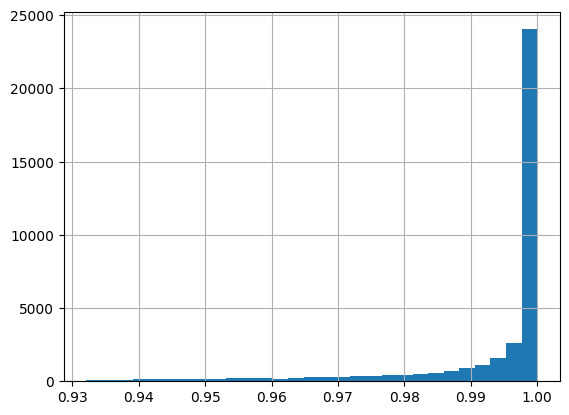

In [28]:

b=np.max(a, axis=1)
plt.hist(b, bins=np.linspace(np.percentile(b, 15), np.percentile(b, 100), num=30), cumulative=False, density=False)
plt.grid()
plt.show()

In [41]:
tsne=TSNE(2, init='random', early_exaggeration=32, verbose=1)
tsne_items_embeddings=tsne.fit_transform(np.vstack([items_embeddings, gm_means, kmeans_means]))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 43114 samples in 0.003s...
[t-SNE] Computed neighbors for 43114 samples in 2.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 43114
[t-SNE] Computed conditional probabilities for sample 2000 / 43114
[t-SNE] Computed conditional probabilities for sample 3000 / 43114
[t-SNE] Computed conditional probabilities for sample 4000 / 43114
[t-SNE] Computed conditional probabilities for sample 5000 / 43114
[t-SNE] Computed conditional probabilities for sample 6000 / 43114
[t-SNE] Computed conditional probabilities for sample 7000 / 43114
[t-SNE] Computed conditional probabilities for sample 8000 / 43114
[t-SNE] Computed conditional probabilities for sample 9000 / 43114
[t-SNE] Computed conditional probabilities for sample 10000 / 43114
[t-SNE] Computed conditional probabilities for sample 11000 / 43114
[t-SNE] Computed conditional probabilities for sample 12000 / 43114
[t-SNE] Computed conditional probabilities for sam

In [32]:
_,a = np.unique(item_labels, return_counts=True)
_,b = np.unique(item_labels_kmeans, return_counts=True)
for i in range(no_clusters):
    print(i, f'gmm:  {a[i]:<6}, kmeans: {b[i]}')

0 gmm:  827   , kmeans: 4167
1 gmm:  11799 , kmeans: 4759
2 gmm:  1203  , kmeans: 7546
3 gmm:  5676  , kmeans: 4905
4 gmm:  10117 , kmeans: 5663
5 gmm:  11823 , kmeans: 5252
6 gmm:  152   , kmeans: 5863
7 gmm:  1501  , kmeans: 4943


In [59]:
from itertools import product
from tqdm import tqdm as progress_bar

In [33]:

#for perp, ea, init_alg in progress_bar(product([8, 16, 32, 64], [8,16,32,64], ['random','pca']), total=32):

#tsne=TSNE(2, init=init_alg, early_exaggeration=ea, perplexity=perp, verbose=0, n_iter=2000)
#tsne_items_embeddings=tsne.fit_transform(np.vstack([items_embeddings, gm_means, kmeans_means]))

fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne_items_embeddings[:-2*no_clusters][item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

for c in range(no_clusters):
    fig.add_trace(go.Scatter(x=[tsne_items_embeddings[-2*no_clusters+c, 0]], y=[tsne_items_embeddings[-2*no_clusters+c, 1]], 
                            name=str(c), mode='markers', 
                            marker=dict(size=12,
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))


fig.update_layout(title=f'TSNE reduced items embeddings with GM with {init_params} init, tol {tol},{covariance_type} covariance matrix',
                margin=dict(l=40, r=40, t=40, b=40),
                width=1000, height=800)
fig.write_html(f'./images/items_tsne_{tsne.init}_perpexlity_{tsne.perplexity}_ea_{tsne.early_exaggeration}_GMM_{no_clusters}_{init_params}_{covariance_type}_{tol}_{opt.dataset}_{opt.hiddenSize}_{global_run_id.split("-")[-1]}.html')
del fig

In [34]:
fig = go.Figure()

for label in np.unique(item_labels_kmeans):
    label_embedding=tsne_items_embeddings[:-2*no_clusters][item_labels_kmeans==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

for c in range(no_clusters):
    fig.add_trace(go.Scatter(x=[tsne_items_embeddings[-no_clusters+c, 0]], y=[tsne_items_embeddings[-no_clusters+c, 1]], 
                             name=str(c), mode='markers', 
                             marker=dict(size=12,
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))


fig.update_layout(title='TSNE reduced items embeddings with Kmeans',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_tsne_KMEANS_{tsne.init}_{no_clusters}_{init_params}_{opt.dataset}_{opt.hiddenSize}_{global_run_id.split("-")[-1]}.html')
del fig

## single session example

In [35]:
with open('../datasets/' + opt.dataset + '/test.txt', 'rb') as f:
    test_data = pickle.load(f)

In [1]:
IDXS=[len(i)>8 for i in test_data[0]]
long_sessions=np.arange(len(test_data[0]))[IDXS]

NameError: name 'test_data' is not defined

In [110]:
idx=np.random.choice(long_sessions)

seqence=test_data[0][idx]
target=test_data[1][idx]
idx, mrr[idx], item_labels[seqence], item_labels[target]

(51388, 0.0, array([1, 1, 1, 1, 1, 4, 4, 1, 4]), 4)

In [111]:
l=[]
for i in range(1, len(seqence)):
    print(f'{i-1}->{i}',np.linalg.norm(items_embeddings[seqence[i]]-items_embeddings[seqence[i-1]]))
print('last->target',np.linalg.norm(items_embeddings[seqence[-1]]-items_embeddings[target]))

0->1 1.1324658
1->2 0.9807097
2->3 1.2016445
3->4 1.3390483
4->5 0.8861976
5->6 0.8227661
6->7 1.1084119
7->8 1.1084119
last->target 1.070477


In [122]:
seqence

[18613, 19338, 7139, 15094, 18612, 41103, 37910, 25758, 37910]

In [118]:
import plotly.express as px
colors=px.colors.qualitative.Plotly

In [119]:
fig = go.Figure()

for label in np.unique(item_labels):#[np.unique(item_labels, return_counts=True)[1]>len(item_labels)/ngmm]:
    label_embedding=tsne_items_embeddings[:-2*no_clusters][item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers', opacity=1))

for i, item in enumerate(seqence):#[np.unique(item_labels, return_counts=True)[1]>len(item_labels)/ngmm]:
    sequence_embedding=tsne_items_embeddings[item]
    fig.add_trace(go.Scatter(x=[sequence_embedding[0]], y=[sequence_embedding[1]], 
                             name=f'item_{i}', mode='markers', 
                             marker=dict(size=20,
                                         color=colors[item_labels[item]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))
    
fig.add_trace(go.Scatter(x=[tsne_items_embeddings[target][0]], y=[tsne_items_embeddings[target][1]], 
                             name=f'target', mode='markers', 
                            marker=dict(size=30,
                                      color=colors[item_labels[target]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))

sequence_embedding=tsne_items_embeddings[seqence]
fig.add_trace(go.Scatter(x=sequence_embedding[:, 0], y=sequence_embedding[:, 1], 
                             name='session', mode='markers+lines', 
                             marker=dict(symbol="arrow",
                                        size=15,
                                        angleref="previous",
                                        color='Black')
                                        ))

fig.add_trace(go.Scatter(x=[sequence_embedding[-1, 0], tsne_items_embeddings[target][0]],
                          y=[sequence_embedding[-1, 1], tsne_items_embeddings[target][1]], 
                             name='prediciton', mode='markers+lines', 
                             marker=dict(symbol="arrow",
                                        size=15,
                                        angleref="previous",
                                        color='Red')
                                        ))
    
fig.update_layout(title='',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/sequence_tsne_{tsne.init}_{opt.dataset}_{no_clusters}_{run_id.split("-")[-1]}.html')
del fig

In [40]:
items_df.loc[items_df.item_number.isin(seqence)].copy().set_index('item_number').loc[seqence]

,item_id,pricelog2,product.name.tokens,category,frequency
item_number,,,,,
42776,391312,9,"18900,18900,528642",316,25
43052,383974,0,"527974,8130,8130",23,5
3397,22028,8,"37,37,15034",416,61
40897,251104,8,"4529,47,47",416,5
4219,133577,10,"59070,59070,508666",416,24
24223,48379,8,"2785,3167,2783,2783",562,65
40322,65764,8,"2770,2770,399729",562,27
38575,30789,8,"116362,58302,58302",562,47


# SERP info (diginetica only)

## calculate statistics

In [176]:
clicks_df=df=pd.read_csv('../datasets/train-item-views.csv', sep=';', 
                          names=['session_id','userId','item_id','timeframe','eventdate'], 
                          dtype={'item_id':str}).sort_values(by=['session_id','timeframe']).reset_index(drop=True)


/tmp/ipykernel_8516/1821352848.py:4: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



In [21]:
qu_df=pd.read_csv('../datasets/train-queries.csv', sep=';').rename(columns={
    'sessionId':'session_id','categoryId':'category','items':'serp', 'queryId':'query_id'
}).sort_values(by=['session_id','timeframe','query_id']).reset_index(drop=True)

/tmp/ipykernel_14967/3225500134.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  qu_df=pd.read_csv('../datasets/train-queries.csv', sep=';').rename(columns={


In [161]:
items_df.head()

,item_id,pricelog2,product.name.tokens,category,item_number,frequency
0,69585,6,"7583,18117,41805,41805,2371",176,7556,45
1,90939,6,"604,18117,41805,41805,2371",176,1245,10
2,69586,0,"2936,18117,41805,41805,2371",176,15895,13
3,30029,7,"4668,41805,41805,56652",176,5037,24
4,7492,9,"3011,4632,10402,9562,9562,11721",684,9655,188


In [22]:
def get_query_for_session_clicks(sid):
    q=qu_df.loc[qu_df.session_id==sid]
    s=clicks_df.loc[clicks_df.session_id==sid]
    qids=[]
    serps=[]
    for timeframe in s.timeframe:
        idxs=(q.timeframe<timeframe).values
        vals=q.query_id.values[idxs]
        s_vals=q.serp.values[idxs]
        qid=np.nan
        serp=np.nan
        if len(vals):
            qid=vals[-1]
            serp=s_vals[-1]
        qids.append(qid)
        serps.append(serp)
    return (sid, qids, serps)

In [185]:
serp_df=pd.DataFrame([get_query_for_session_clicks(sid) for sid in clicks_df.session_id.unique()], columns=['session_id','query_id','serp'])

In [196]:
clicks_df['query_id']=serp_df.explode(column=['query_id','serp']).query_id.values
clicks_df['serp']=serp_df.explode(column=['query_id','serp']).serp.values

In [131]:
clicks_df.head()

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp
0,1,NaN,9654,75848,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.065199,199.0,0.976442
1,1,NaN,33043,173912,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.093988,199.0,0.819720
2,1,NaN,32118,243569,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.062659,199.0,0.786291
3,1,NaN,12352,329870,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.132091,199.0,0.881767
4,1,NaN,35077,390072,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.136325,199.0,0.867209


In [23]:
def item_pos_in_serp(row):
    if row.query_id is np.nan:
        return -1
    serp=row.serp.split(',')
    if str(row.item_id) in serp:
        return serp.index(str(row.item_id))/len(row.serp)
    else: return -1

In [229]:
clicks_df['serp_pos']=clicks_df.apply(lambda r: item_pos_in_serp(r), axis=1, )
clicks_df['serp_len']=clicks_df.apply(lambda r: np.nan if r.serp is np.nan else len(r.serp.split(',')), axis=1, )

In [231]:
#clicks_df.to_csv('../datasets/diginetica/clicks_df.csv')

In [18]:
#clicks_df=pd.read_csv('../datasets/diginetica/clicks_df.csv').drop(columns='Unnamed: 0')

In [22]:
clicks_df.head()

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len
0,1,NaN,9654,75848,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.065199,199.0
1,1,NaN,33043,173912,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.093988,199.0
2,1,NaN,32118,243569,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.062659,199.0
3,1,NaN,12352,329870,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.132091,199.0
4,1,NaN,35077,390072,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.136325,199.0


In [130]:
print('Number of catagories in both queries and items: ', len(set(qu_df.category.unique()) & set(items_df.category.unique())))

962

In [25]:
item_dict={}
for _, r in tqdm(items_df.iterrows()):
    item_dict[r.item_id]=r.item_number

43097it [00:01, 34855.27it/s]


In [26]:
def serp_center(qid, serp):
    if serp is np.nan:
        return (qid, np.nan)
    items=[]
    for i in serp.split(','):
        if int(i) in item_dict.keys():
            items.append(item_dict[int(i)])
    if items:
        embs=get_items_embedding(model, torch.tensor(items, device=model.device)).cpu().detach().numpy()
        return (qid, np.average(embs, axis=0))
    return (qid, np.nan)

In [28]:
q_serp_dict=(clicks_df[['query_id', 'serp']].drop_duplicates().apply(lambda r: serp_center(r.query_id, r.serp), axis=1))
q_serp_dict=dict([x for x in q_serp_dict])

In [27]:
def get_dist_form_serp(r):
    if (int(r.item_id) in item_dict.keys()) and not np.isnan(r.query_id):
        return np.linalg.norm(items_embeddings[item_dict[int(r.item_id)]]-q_serp_dict[r.query_id]) 
    else: return np.nan

In [29]:
dist_from_serp=clicks_df.apply(lambda r: get_dist_form_serp(r), axis=1).values

In [30]:
clicks_df['dist_from_serp']=dist_from_serp

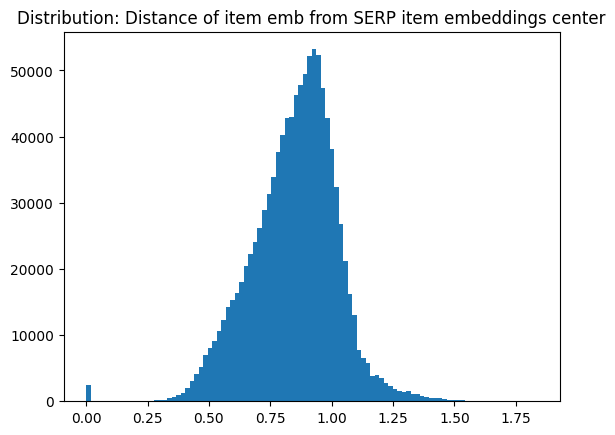

In [33]:
plt.hist(dist_from_serp, bins=100)
plt.title('Distribution: Distance of item emb from SERP item embeddings center')
plt.show()

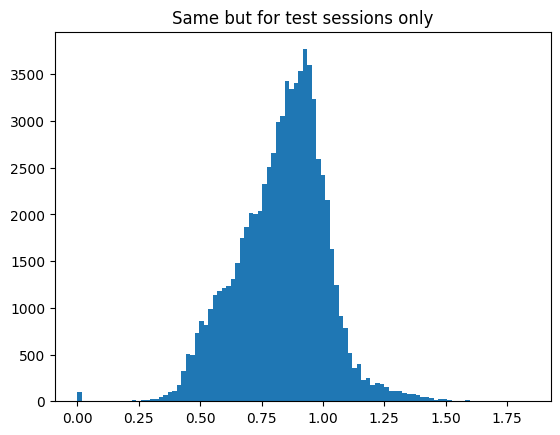

In [34]:
plt.hist(clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].dist_from_serp, bins=100)
plt.title('Same but for test sessions only')
plt.show()

In [155]:
clicks_df['item_number']=clicks_df.item_id.map(lambda x: item_dict[int(x)] if int(x) in item_dict.keys() else -1)

In [35]:
session_df.loc[session_df.session_id==100083]

,length,frequency,no_categories,target_category,target,session_id,hit,mrr
5,3,269.0,1,False,23671,100083,False,0.0
6,1,502.0,1,True,36257,100083,True,0.3333333432674408
7,2,391.0,1,True,42615,100083,False,0.0


In [36]:
clicks_df.loc[clicks_df.session_id==100083]

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp,item_number,no_clusters_serp,target_cluster_proportion,serp_abs_pos,search_query
304116,100083,NaN,376301,11074,2016-05-26,617707.0,"82598,39360,32775,176612,10557,33037,27802,155...",0.122050,189.0,1.039145,38882,2.0,0.994681,23.0,False
304117,100083,NaN,181526,68526,2016-05-26,617707.0,"82598,39360,32775,176612,10557,33037,27802,155...",0.049634,189.0,0.939668,36257,2.0,0.994681,9.0,False
304118,100083,NaN,387877,146509,2016-05-26,617707.0,"82598,39360,32775,176612,10557,33037,27802,155...",NaN,189.0,0.939321,42615,2.0,0.994681,NaN,False
304119,100083,NaN,12459,376339,2016-05-26,737542.0,"1646,129592,9125,31613,16335,9126,83278,83280,...",0.061086,136.0,0.941409,23671,5.0,0.784810,8.0,False


In [190]:
clicks_df.serp_pos=clicks_df.serp_pos.map(lambda x: x if x>=0 else np.nan)

In [ ]:
def is_search_query(qid):
    st=qu_df.loc[qu_df.query_id==qid]['searchstring.tokens']
    if st.shape[0]!=1:
        return False
    st=st.item()
    if isinstance(st, float):
        return False
    return True

In [ ]:
search_query_dict={}
for qid in (clicks_df.query_id.unique()):#, total=clicks_df.query_id.nunique()):
    search_query_dict[qid]=is_search_query(qid)

sq_idxs=clicks_df.query_id.map(lambda x: x if np.isnan(x) else search_query_dict[x])

In [ ]:
clicks_df['search_query']=sq_idxs
clicks_df['serp_abs_pos']=(clicks_df.serp_pos*clicks_df.serp_len).round()

In [43]:
clicks_df.to_csv('../datasets/diginetica/clicks_df.csv')

## reload clicks_df

In [20]:
clicks_df=pd.read_csv('../datasets/diginetica/clicks_df.csv').drop(columns='Unnamed: 0')

## correlations

In [22]:
corr_df=clicks_df[['session_id','item_id', 'serp_pos', 'dist_from_serp', 'item_number', 'serp_len']].merge(session_df, 
                                                                                       left_on=['session_id','item_number'], 
                                                                                       right_on=['session_id','target'])

In [23]:
corr_df

,session_id,item_id,serp_pos,dist_from_serp,item_number,serp_len,length,frequency,no_categories,target_category,target,hit,mrr
0,289,64068,-1.000000,1.109931,20071,19.0,1,10.0,1,False,20071,False,0.0
1,289,133346,-1.000000,1.130447,8762,19.0,2,20.0,2,False,8762,True,0.3333333432674408
2,289,438457,0.142643,0.683961,21566,198.0,5,18.4,4,True,21566,True,0.125
3,289,438457,0.142643,0.683961,21566,198.0,3,25.333333333333332,3,False,21566,False,0.0
4,289,198930,0.147147,0.538785,6381,198.0,4,20.5,4,True,6381,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91269,600404,1168,0.002602,0.759773,19589,180.0,1,45.0,1,True,19589,True,0.25
91270,600608,1813,0.036515,0.789202,5820,200.0,1,197.0,1,True,5820,True,0.0714285746216774
91271,600608,31789,0.037344,0.938444,3600,200.0,2,152.0,1,True,3600,True,0.10000000149011612
91272,600674,1152,0.025381,0.700841,10040,185.0,1,64.0,1,True,10040,False,0.0


In [24]:
from scipy.stats import pearsonr, spearmanr

In [25]:
corr_df.hit=corr_df.hit.map(lambda x: 1 if x else 0)
corr_df.mrr=corr_df.mrr.astype(float)

In [32]:
corr_df[['dist_from_serp','serp_pos','hit','mrr','serp_len']].dtypes

dist_from_serp    float64
serp_pos          float64
hit                 int64
mrr               float64
serp_len          float64
dtype: object

In [33]:
spearmanr(corr_df[['dist_from_serp','serp_pos','mrr','serp_len']].dropna(), 
     #     corr_df[['dist_from_serp','serp_pos','hit','mrr','serp_len']].dropna(),
          )

SignificanceResult(statistic=array([[ 1.        , -0.17637168,  0.15382035,  0.19972637],
       [-0.17637168,  1.        ,  0.12060617,  0.04844716],
       [ 0.15382035,  0.12060617,  1.        , -0.05057548],
       [ 0.19972637,  0.04844716, -0.05057548,  1.        ]]), pvalue=array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 4.37983404e-289,
        5.73132069e-048],
       [0.00000000e+000, 4.37983404e-289, 0.00000000e+000,
        4.03576181e-052],
       [0.00000000e+000, 5.73132069e-048, 4.03576181e-052,
        0.00000000e+000]]))

## center/span of item embeddings

In [37]:
# average center of embb space
items_center=np.average(items_embeddings, axis=0)

In [38]:
print('Max distnace between any two items: ', np.linalg.norm(np.max(items_embeddings, axis=0) - np.min(items_embeddings, axis=0)))

Max distnace between any two items:  7.861786


## SERP vs Target clusters

In [42]:
clicks_df.head()

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp,item_number,no_clusters_serp,target_cluster_proportion,serp_abs_pos,search_query
0,1,NaN,9654,75848,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.065199,199.0,1.077654,1890,6.0,0.892216,13.0,False
1,1,NaN,33043,173912,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.093988,199.0,0.967971,2460,6.0,0.892216,19.0,False
2,1,NaN,32118,243569,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.062659,199.0,0.905199,2558,6.0,0.892216,12.0,False
3,1,NaN,12352,329870,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.132091,199.0,1.058083,3012,6.0,0.892216,26.0,False
4,1,NaN,35077,390072,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.136325,199.0,0.941578,8171,6.0,0.892216,27.0,False


In [44]:
clicks_df.serp_pos=clicks_df.serp_pos.map(lambda x: np.nan if x==-1 else x)

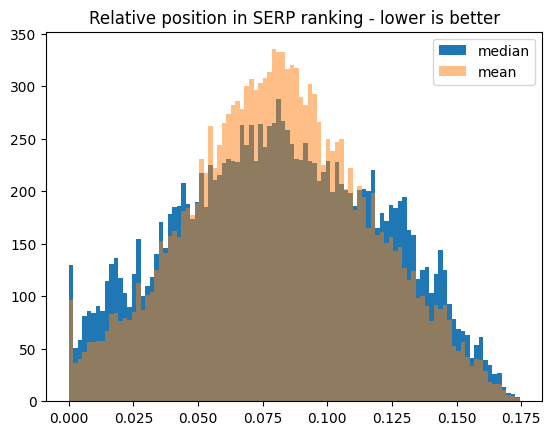

In [45]:
plt.hist(clicks_df[['session_id','serp_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').median('serp_pos').serp_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, alpha=0.5, label='mean')
plt.title('Relative position in SERP ranking - lower is better')
plt.legend()
plt.show()

In [61]:
clicks_df.head()

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp,item_number,no_clusters_serp,target_cluster_proportion,serp_abs_pos,search_query
0,1,NaN,9654,75848,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.065199,199.0,1.077654,1890,6.0,0.892216,13.0,False
1,1,NaN,33043,173912,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.093988,199.0,0.967971,2460,6.0,0.892216,19.0,False
2,1,NaN,32118,243569,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.062659,199.0,0.905199,2558,6.0,0.892216,12.0,False
3,1,NaN,12352,329870,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.132091,199.0,1.058083,3012,6.0,0.892216,26.0,False
4,1,NaN,35077,390072,2016-05-09,890364.0,"7518,69648,71,30254,80775,30311,342,7837,81099...",0.136325,199.0,0.941578,8171,6.0,0.892216,27.0,False


In [75]:
session_df['targetXsid']=list(zip(session_df.target.values, session_df.session_id.values))
clicks_df['targetXsid']=list(zip(clicks_df.item_number.values, clicks_df.session_id.values))

hit_targetXsid=session_df.loc[session_df.hit.values=='True'].targetXsid.values

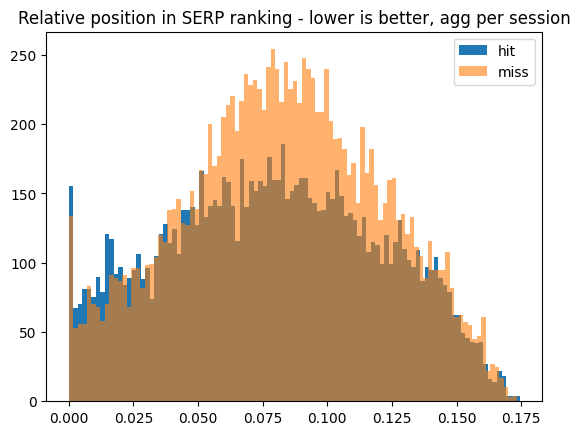

In [90]:
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, label='hit')

plt.hist(clicks_df[['session_id','serp_pos']].loc[(~clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, label='miss', alpha=0.6)
plt.title('Relative position in SERP ranking - lower is better, agg per session')
plt.legend()
plt.show()

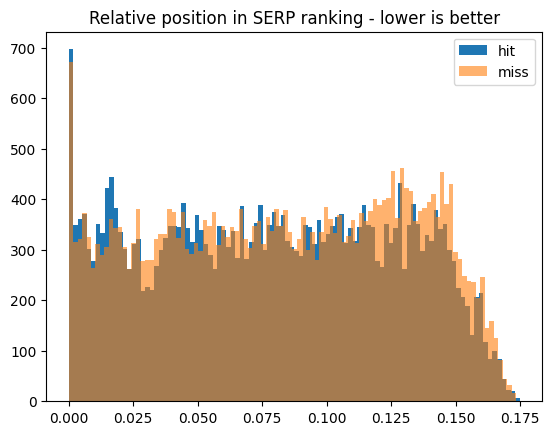

In [89]:
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .dropna().serp_pos, bins=100, label='hit')

plt.hist(clicks_df[['session_id','serp_pos']].loc[(~clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .dropna().serp_pos, bins=100, label='miss', alpha=0.6)
plt.title('Relative position in SERP ranking - lower is better')
plt.legend()
plt.show()

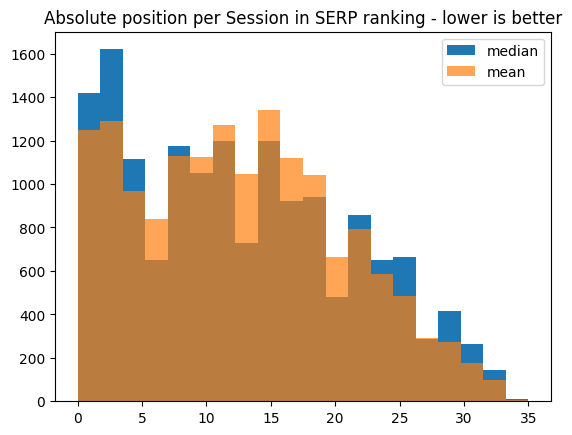

In [85]:
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').median('serp_abs_pos').serp_abs_pos, bins=20, label='median')
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[clicks_df.session_id.isin(test_session_ids)]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=20, alpha=0.7, label='mean')
plt.title('Absolute position per Session in SERP ranking - lower is better')
plt.legend()
plt.show()

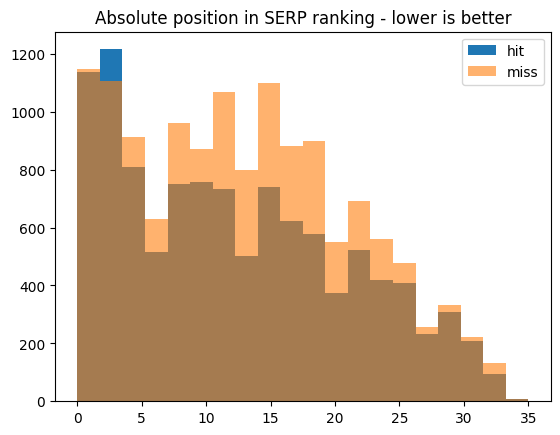

In [88]:
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=20, label='hit')

plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(~clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=20, label='miss', alpha=0.6)
plt.title('Absolute position in SERP ranking - lower is better')
plt.legend()
plt.show()

### seperate search queries

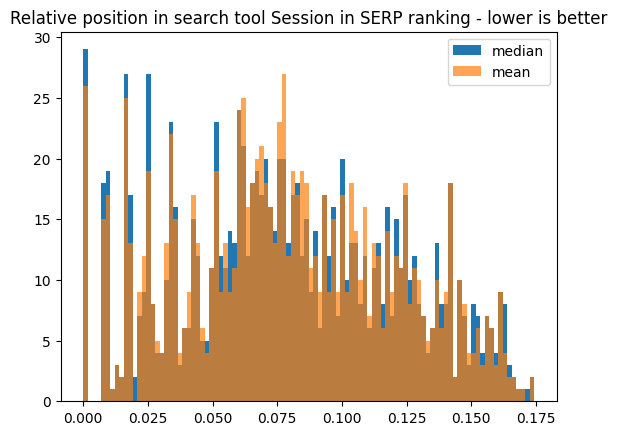

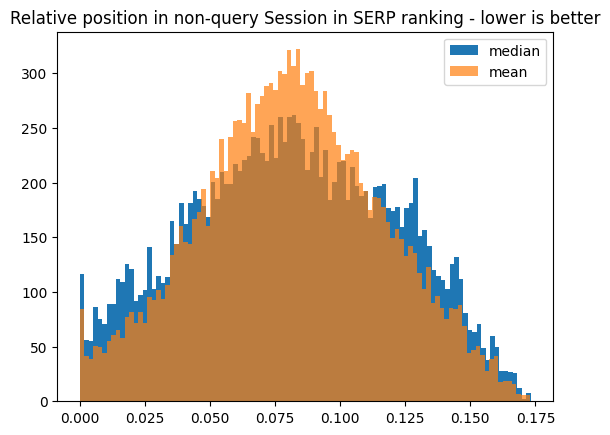

In [92]:
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').median('serp_pos').serp_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, alpha=0.7, label='mean')
plt.title('Relative position in search tool Session in SERP ranking - lower is better')
plt.legend()
plt.show()

plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').median('serp_pos').serp_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').mean('serp_pos').serp_pos, bins=100, alpha=0.7, label='mean')
plt.title('Relative position in non-query Session in SERP ranking - lower is better')
plt.legend()
plt.show()

In [95]:
clicks_df.search_query.unique()

array([False, True, nan], dtype=object)

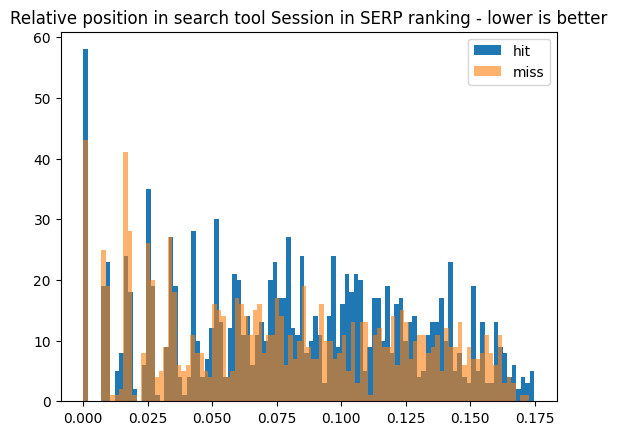

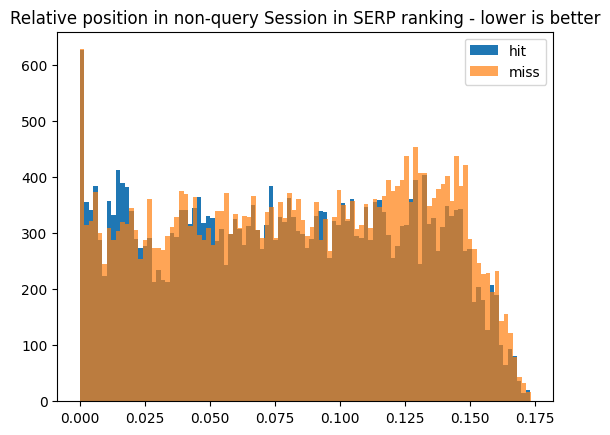

In [97]:
plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))
                                                  &(clicks_df.search_query)]\
         .dropna().serp_pos, bins=100, label='hit')

plt.hist(clicks_df[['session_id','serp_pos']].loc[(~clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))
                                                  &(clicks_df.search_query)]\
         .dropna().serp_pos, bins=100, label='miss', alpha=0.6)
plt.title('Relative position in search tool Session in SERP ranking - lower is better')
plt.legend()
plt.show()

plt.hist(clicks_df[['session_id','serp_pos']].loc[(clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().serp_pos, bins=100, label='hit')
plt.hist(clicks_df[['session_id','serp_pos']].loc[(~clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().serp_pos, bins=100, alpha=0.7, label='miss')
plt.title('Relative position in non-query Session in SERP ranking - lower is better')
plt.legend()
plt.show()

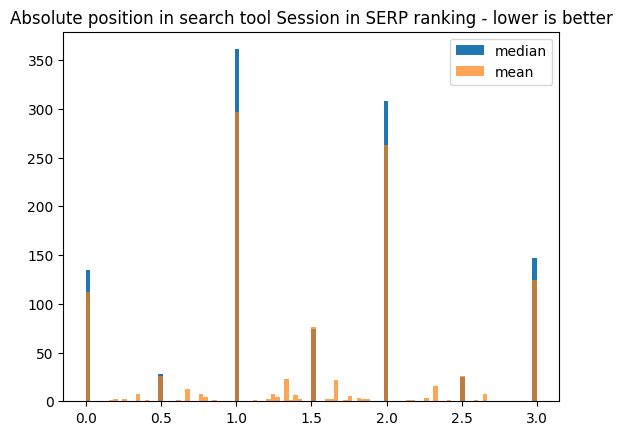

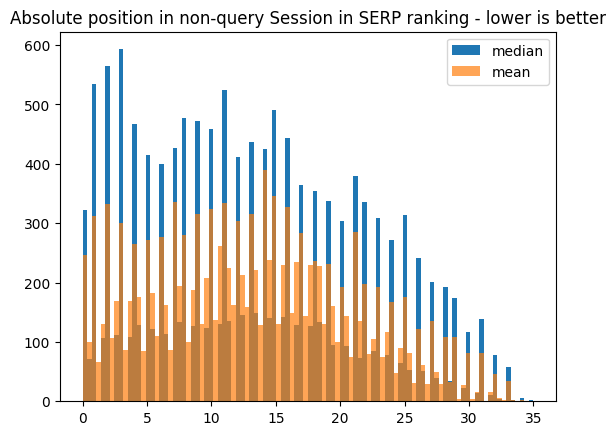

In [282]:
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').median('serp_abs_pos').serp_abs_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query)]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=100, alpha=0.7, label='mean')
plt.title('Absolute position in search tool Session in SERP ranking - lower is better')
plt.legend()
plt.show()

plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').median('serp_abs_pos').serp_abs_pos, bins=100, label='median')
plt.hist(clicks_df[['session_id','serp_abs_pos']].loc[(clicks_df.session_id.isin(test_session_ids))
                                                      &(clicks_df.search_query!=True)]\
         .dropna().groupby('session_id').mean('serp_abs_pos').serp_abs_pos, bins=100, alpha=0.7, label='mean')
plt.title('Absolute position in non-query Session in SERP ranking - lower is better')
plt.legend()
plt.show()

### distnace from SERP centre

In [140]:
import plotly.express as px
import plotly.graph_objects as go

colors=px.colors.qualitative.Plotly

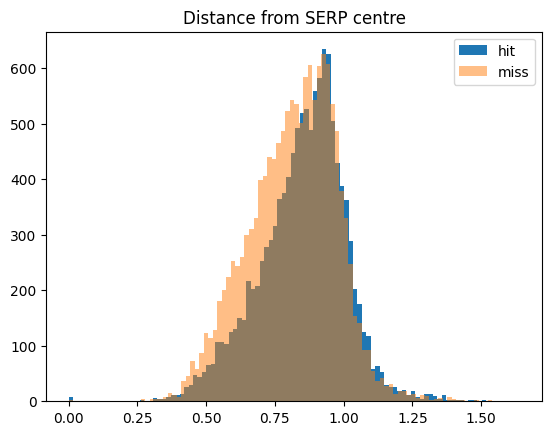

In [101]:
plt.hist(clicks_df[['session_id','dist_from_serp']].loc[(clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .groupby('session_id').median('dist_from_serp').dist_from_serp, bins=100, label='hit')
plt.hist(clicks_df[['session_id','dist_from_serp']].loc[(~clicks_df.targetXsid.isin(hit_targetXsid))
                                                  &(clicks_df.session_id.isin(test_session_ids))]\
         .groupby('session_id').median('dist_from_serp').dist_from_serp, bins=100, alpha=0.5, label='miss')
plt.title('Distance from SERP centre')
plt.legend()
plt.show()

In [137]:
# ciekawe przypadki
# 2137, 10, 1488, 69
#1044

idx=np.random.choice(list(test_session_ids))

sample=clicks_df.loc[clicks_df.session_id==idx]
sample

,session_id,userId,item_id,timeframe,eventdate,query_id,serp,serp_pos,serp_len,dist_from_serp,item_number,no_clusters_serp,target_cluster_proportion,serp_abs_pos,search_query,targetXsid
362878,118945,NaN,35824,31766,2016-05-30,786597.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.121343,193.0,0.846071,7470,5.0,0.734043,23.0,False,"(7470, 118945)"
362879,118945,NaN,79002,94734,2016-05-30,786597.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.088640,193.0,0.904135,26145,5.0,0.734043,17.0,False,"(26145, 118945)"
362880,118945,NaN,124825,154868,2016-05-30,786597.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.028399,193.0,0.773953,7258,5.0,0.734043,5.0,False,"(7258, 118945)"
362881,118945,NaN,375655,235213,2016-05-30,786597.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.161790,193.0,0.818182,39933,5.0,0.734043,31.0,False,"(39933, 118945)"
362882,118945,NaN,12975,297487,2016-05-30,786597.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.095525,193.0,0.852493,7560,5.0,0.734043,18.0,False,"(7560, 118945)"
362883,118945,NaN,31954,462590,2016-05-30,140374.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.021349,193.0,0.866268,8719,5.0,0.721925,4.0,False,"(8719, 118945)"
362884,118945,NaN,73093,764724,2016-05-30,881622.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.023057,193.0,0.838125,39953,5.0,0.721925,4.0,False,"(39953, 118945)"
362885,118945,NaN,199545,803050,2016-05-30,881622.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.011102,193.0,0.793932,36767,5.0,0.721925,2.0,False,"(36767, 118945)"
362886,118945,NaN,31342,866421,2016-05-30,881622.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.001708,193.0,0.913634,32266,5.0,0.721925,0.0,False,"(32266, 118945)"
362887,118945,NaN,31342,927658,2016-05-30,881622.0,"31256,50284,31342,16108,50310,50344,39585,8801...",0.001708,193.0,0.913634,32266,5.0,0.721925,0.0,False,"(32266, 118945)"


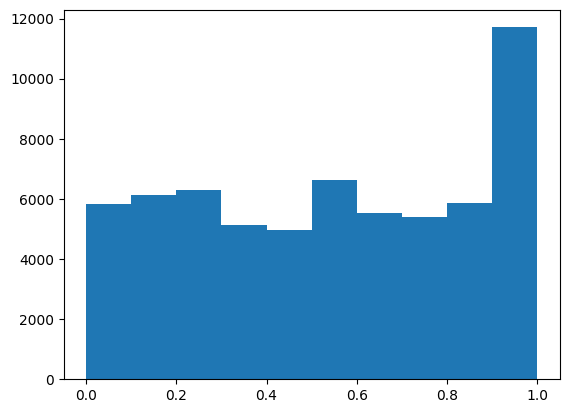

In [152]:
plt.hist(clicks_df.drop_duplicates(subset='serp').target_cluster_proportion)#, bins=np.arange(1, 11))
plt.show()

In [155]:
np.unique(labels, return_counts=True)

(array([0, 3, 4, 5, 6, 7]), array([  5,  49,   1,  15,   4, 114]))

In [156]:
(49+114)/sum([  5,  49,   1,  15,   4, 114])

0.8670212765957447

In [153]:
fig = go.Figure()

embs=[]
labels=[]
for iid in sample.serp.unique()[0].split(','):
    try:
        embs.append(tsne_items_embeddings[item_dict[int(iid)]])
        labels.append(item_labels[item_dict[int(iid)]])
    except KeyError:
        continue

embs=np.array(embs)
labels=np.array(labels)
for label in set(labels):
    idxs=labels==label
    label_embedding=embs[idxs]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), marker={'color':colors[label]}, mode='markers'))
for j,(i,r) in enumerate(sample.iterrows()):
    fig.add_trace(go.Scatter(x=[tsne_items_embeddings[r.item_number, 0]], 
                                y=[tsne_items_embeddings[r.item_number, 1]], 
                                name=f'item_{j+1}_cluster_{item_labels[r.item_number]}', mode='markers', 
                                #legendgroup='session_items',
                                marker=dict(size=12,
                                            color=colors[item_labels[r.item_number]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))


fig.update_layout(title=f'Single SERP items embeddings with GM clusters. Search Query = {is_search_query(sample.query_id.unique()[0])}',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

### aggregate above info

In [ ]:
query_serp_clusters_dict={}
for _,r in tqdm(clicks_df[['query_id','serp']].drop_duplicates().iterrows()):
    labels=[]
    if not r.serp is np.nan:
        for iid in r.serp.split(','):
            try:
                labels.append(item_labels[item_dict[int(iid)]])
            except KeyError:
                continue
        query_serp_clusters_dict[r.query_id]=np.unique(labels, return_counts=True)

In [178]:
def get_serpXcluster_info(r):
    if r.item_number<0:
        return np.nan, np.nan
    try:
        vals,counts=query_serp_clusters_dict[r.query_id]
        no_vals=vals.shape[0]
        proportion=0
        if item_labels[r.item_number] in vals:
            i=vals.tolist().index(item_labels[r.item_number])
            proportion=counts[i]/sum(counts)
    except KeyError:
        return (np.nan, np.nan)
    return no_vals, proportion

In [179]:
pom=clicks_df.apply(lambda r: get_serpXcluster_info(r), axis=1)
clicks_df['no_clusters_serp']=[x[0] for x in pom]
clicks_df['target_cluster_proportion']=[x[1] for x in pom]
del pom

In [286]:
#clicks_df.to_csv('../datasets/diginetica/clicks_df.csv')

In [220]:
clicks_df.loc[(clicks_df.target_cluster_proportion>=0.7)
              &(clicks_df.session_id.isin(test_session_ids))].shape[0]/clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].target_cluster_proportion.dropna().shape[0]

0.5213398091658616

In [240]:
clicks_df.query_id.unique()

array([890364.,  46555.,  46562., ..., 980490., 980493., 980503.])

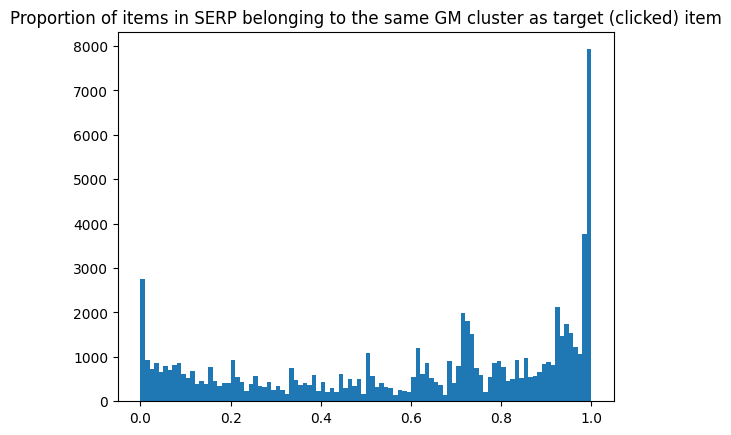

In [224]:
plt.hist(clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].target_cluster_proportion.dropna(), bins=100)
plt.title('Proportion of items in SERP belonging to the same GM cluster as target (clicked) item')
plt.show()

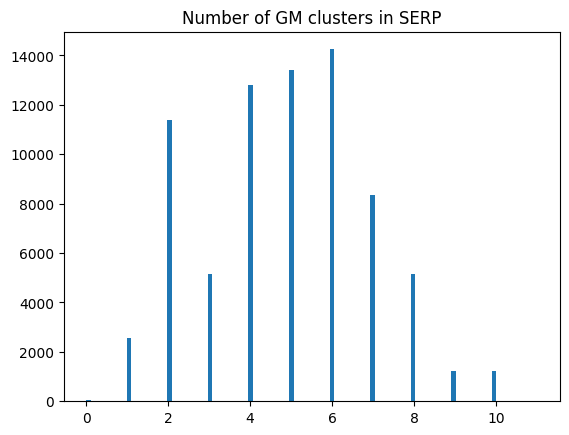

In [221]:
plt.hist(clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].no_clusters_serp.dropna(), bins=100)
plt.title('Number of GM clusters in SERP')
plt.show()

## autoencoder on item embbedings

In [82]:
from torch import nn

In [86]:
class Encoder(nn.Module):
    def __init__(self):
        """Encoder.

        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(opt.hiddenSize, 32), 
            nn.Tanh(),
            nn.Linear(32, 8), 
            nn.Tanh(),
            nn.Linear(8, 2), 
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

In [85]:
class Decoder(nn.Module):
    def __init__(self):
        """Decoder.

        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8), 
            nn.Tanh(),
            nn.Linear(8, 32), 
            nn.Tanh(),
            nn.Linear(32, 100), 
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

In [87]:
from torch import optim

In [129]:
class Autoencoder(pl.LightningModule):
    def __init__(
        self, lr
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = Encoder()
        self.decoder = Decoder()
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, opt.hiddenSize)
        self.loss=nn.MSELoss()
        self.lr=lr

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)."""
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = self.loss(x, x_hat)
      #  loss = loss.mean()
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=5, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)

In [89]:
import torch.utils.data as data_utils


In [94]:
class ItemDataset(data_utils.Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X=X
        self.Y=Y

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [95]:
train_idxs=np.random.randint(0, item_labels.shape[0], size=int(item_labels.shape[0]*0.8))
val_idxs=[x for x in range(item_labels.shape[0]) if not x in train_idxs]

items_train_dataloader=data_utils.DataLoader(ItemDataset(items_embeddings[train_idxs], item_labels[train_idxs]),
                                             batch_size=32, num_workers=os.cpu_count(),
                                             shuffle=True, drop_last=True)
items_val_dataloader=data_utils.DataLoader(ItemDataset(items_embeddings[val_idxs], item_labels[val_idxs]),
                                             batch_size=32, num_workers=os.cpu_count(),
                                             )

In [99]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint


In [142]:
trainer=pl.Trainer( accelerator="auto",
        devices=1,
        max_epochs=500,
        callbacks=[
            ModelCheckpoint(monitor="val_loss", mode="min"),
            LearningRateMonitor("epoch"),
            EarlyStopping(
                monitor="val_loss", patience=opt.patience, mode="min", check_finite=True
            ),
        ],
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [140]:
autoencoder=Autoencoder(lr=1e-2)

In [141]:
with torch.no_grad():
    # Initialize parameters
    for name, p in autoencoder.named_parameters():
        if "weight" in name:
            #p.normal_(0, 0.5)
            nn.init.xavier_normal_(p)
        elif "bias" in name:
            p.normal_(0, 1e-2)
           # nn.init.xavier_normal_(p)
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

In [143]:
trainer.fit(autoencoder, items_train_dataloader, items_val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes | Out sizes
-----------------------------------------------------------
0 | encoder | Encoder | 3.5 K  | [2, 100] | [2, 2]   
1 | decoder | Decoder | 3.6 K  | [2, 2]   | [2, 100] 
2 | loss    | MSELoss | 0      | ?        | ?        
-----------------------------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.029     Total estimated model params size (MB)


Epoch 38: 100%|██████████| 1077/1077 [00:04<00:00, 250.01it/s, v_num=632, val_loss=0.00844]

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [146]:
ae_item_embeddings=autoencoder.encoder(torch.tensor(items_embeddings, device=autoencoder.device)).cpu().detach().numpy()

In [ ]:
fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=ae_item_embeddings[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))



fig.update_layout(title='AutoEncoder reduced items embeddings with GM',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_AE_{gm.n_components}_{gm.init_params}_{opt.dataset}_{opt.hiddenSize}_{global_run_id.split("-")[-1]}.html')
fig.show()

In [151]:
del items_train_dataloader
del items_val_dataloader
del autoencoder
del trainer
del ae_item_embeddings

## more